In [1]:
import warnings
import pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotnine as gg
import umap
from numba.core.errors import NumbaWarning

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_predict
from dask_searchcv import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix
)

from utils.data_utils import load_data
from utils.ml_utils import get_threshold_metrics, shuffle_columns

from pycytominer.cyto_utils import infer_cp_features

In [2]:
warnings.filterwarnings("ignore", category=NumbaWarning)

In [3]:
def get_threshold_metrics(y_true, y_pred, drop_intermediate=False):
    """
    Retrieve true/false positive rates and auroc/aupr for class predictions
    Arguments:
    y_true - an array of gold standard mutation status
    y_pred - an array of predicted mutation status
    disease - a string that includes the corresponding TCGA study acronym
    Output:
    dict of AUROC, AUPR, pandas dataframes of ROC and PR data, and cancer-type
    """

    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(
        roc_columns,
        roc_curve(y_true, y_pred, drop_intermediate=drop_intermediate)
     )
    roc_df = pd.DataFrame.from_dict(dict(roc_items))

    pr_columns = ['precision', 'recall', 'threshold']
    prec, rec, thresh = precision_recall_curve(y_true, y_pred)
    pr_df = pd.DataFrame.from_records([prec, rec]).transpose()
    pr_df = pd.concat([pr_df, pd.Series(thresh)], ignore_index=True, axis=1)
    pr_df.columns = pr_columns

    auroc = roc_auc_score(y_true, y_pred, average='weighted')
    avg_precision = average_precision_score(y_true, y_pred, average='weighted')
    
    metric_dict = {
        'auroc': auroc,
        'average_precision': avg_precision,
        'roc_df': roc_df,
        'pr_df': pr_df,
    }
    return metric_dict

## Set Parameters

In [4]:
alphas = [0.001, 0.2, 0.3, 0.4, 0.5, 0.6, 1]
l1_ratios = [0.1, 0.2, 0.3, 0.4, 1]
n_folds = 5

## Load Data

In [5]:
x_train_df, y_train_df, meta_train_df, x_test_df, y_test_df, meta_test_df = load_data(
    y_col="Metadata_CellLine", wt_col="WT", return_meta=True, shuffle_row_order=True
)
print(x_train_df.shape)
print(x_test_df.shape)

x_test_df.head(3)

(30021, 909)
(5317, 909)


,Cells_AreaShape_Area,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MaxFeretDiameter,Cells_AreaShape_MeanRadius,Cells_AreaShape_MinFeretDiameter,Cells_AreaShape_MinorAxisLength,Cells_AreaShape_Orientation,...,Nuclei_Texture_SumEntropy_Mito_5_00,Nuclei_Texture_SumEntropy_Mito_5_01,Nuclei_Texture_SumEntropy_Mito_5_02,Nuclei_Texture_SumEntropy_Mito_5_03,Nuclei_Texture_SumEntropy_RNA_10_01,Nuclei_Texture_SumEntropy_RNA_10_03,Nuclei_Texture_SumEntropy_RNA_5_00,Nuclei_Texture_SumEntropy_RNA_5_01,Nuclei_Texture_SumEntropy_RNA_5_02,Nuclei_Texture_SumEntropy_RNA_5_03
0,0.902205,-1.527561,-0.355769,-0.566890,0.232114,0.498951,1.091673,1.181473,1.483826,-0.558620,...,-0.364384,-0.323827,-0.370386,-0.340922,0.403517,0.406989,0.095449,0.258188,0.153958,0.260582
1,0.870369,-1.502094,-0.214548,-0.929938,0.197290,0.250547,1.103569,1.317696,1.418831,0.351987,...,-0.790852,-0.772948,-0.733894,-0.809671,-1.276849,-1.369072,-1.457139,-1.427756,-1.326418,-1.256152
2,-0.195457,-1.319867,0.815628,0.046095,-0.511873,-0.549075,0.268071,0.202636,0.264362,1.739011,...,0.590447,0.634598,0.673680,0.632713,0.050275,0.174358,-0.083266,-0.164787,0.044736,0.126424


In [6]:
# Apply UMAP
reducer = umap.UMAP(random_state=123)
embedding = reducer.fit_transform(x_train_df)

# Setup plotting logic
embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
embedding_df = embedding_df.merge(meta_train_df, left_index=True, right_index=True)

/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 5 x 4 in image.
  from_inches(height, units), units))
/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/umap/example_cell_line_train.png
  warn('Filename: {}'.format(filename))


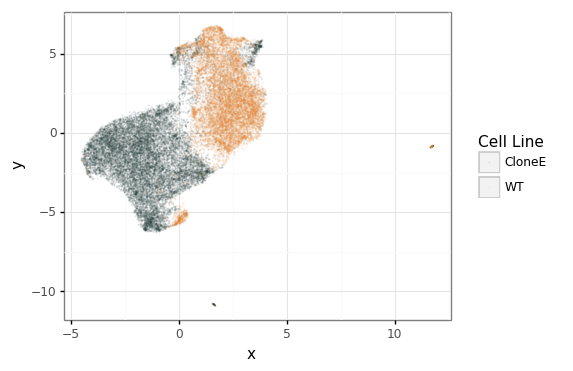

<ggplot: (8792465584262)>

In [7]:
cell_line_gg = (
    gg.ggplot(embedding_df, gg.aes(x="x", y="y")) +
    gg.geom_point(gg.aes(color="Metadata_CellLine"), size = 0.1, shape = ".", alpha = 0.1) +
    gg.theme_bw() +
    gg.scale_color_manual(name="Cell Line",
                          labels={"CloneE": "CloneE", "WT": "WT"},
                          values={"CloneE": "#223C3A", "WT": "#E7822B"})
)

fig_file = pathlib.Path("figures", "umap", "example_cell_line_train.png")
cell_line_gg.save(filename=fig_file, height=4, width=5, dpi=500)

cell_line_gg

/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 5 x 4 in image.
  from_inches(height, units), units))
/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/umap/example_well_train.png
  warn('Filename: {}'.format(filename))


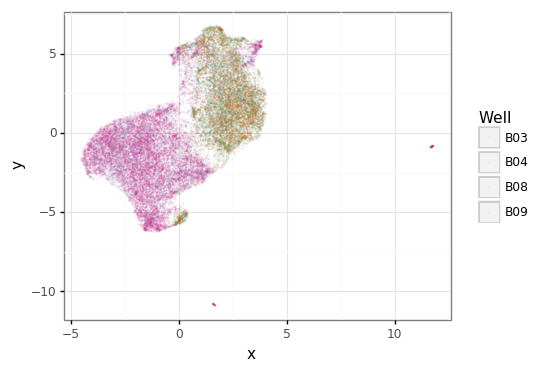

<ggplot: (8792392143978)>

In [8]:
well_gg = (
    gg.ggplot(embedding_df, gg.aes(x="x", y="y")) +
    gg.geom_point(gg.aes(color="Metadata_Well"), size = 0.1, shape = ".", alpha = 0.1) +
    gg.theme_bw() +
    gg.scale_color_manual(name="Well",
                          labels={"B03": "B03", "B04": "B04", "B08": "B08", "B09": "B09"},
                          values={"B03": "#1b9e77", "B04": "#d95f02", "B08": "#7570b3", "B09": "#e7298a"})
)

fig_file = pathlib.Path("figures", "umap", "example_well_train.png")
well_gg.save(filename=fig_file, height=4, width=5, dpi=500)

well_gg

## Setup Pipeline and Fit

In [9]:
clf_parameters = {
    'classify__loss': ['log'],
    'classify__penalty': ['elasticnet'],
    'classify__alpha': alphas,
    'classify__l1_ratio': l1_ratios
}

estimator = Pipeline(
    steps=[(
        'classify',
        SGDClassifier(
            random_state=0,
            class_weight='balanced',
            loss='log',
            max_iter=50,
            tol=1e-3
        )
    )]
)

cv_pipeline = GridSearchCV(
    estimator=estimator,
    param_grid=clf_parameters,
    n_jobs=-1,
    cv=n_folds,
    scoring='average_precision',
    return_train_score=True
)
 
shuffle_cv_pipeline = GridSearchCV(
    estimator=estimator,
    param_grid=clf_parameters,
    n_jobs=-1,
    cv=n_folds,
    scoring='average_precision',
    return_train_score=True
)

In [10]:
# Fit Regular Pipeline
cv_pipeline.fit(X=x_train_df, y=y_train_df.status.tolist())

/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('classify', SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=50,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=0, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       iid=True, n_jobs=-1,
       param_grid={'classify__loss': ['log'], 'classify__penalty': ['elasticnet'], 'classify__alpha': [0.001, 0.2, 0.3, 0.4, 0.5, 0.6, 1], 'classify__l1_ratio': [0.1, 0.2, 0.3, 0.4, 1]},
       refit=True, return_train_score=True, scheduler=None,
       scoring='average_precision')

In [11]:
x_train_shuffled_df = x_train_df.apply(shuffle_columns, axis=0, result_type="broadcast")

In [12]:
# Fit Shuffled Data Pipeline
shuffle_cv_pipeline.fit(X=x_train_shuffled_df, y=y_train_df.status.tolist())

/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


GridSearchCV(cache_cv=True, cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('classify', SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=50,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=0, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       iid=True, n_jobs=-1,
       param_grid={'classify__loss': ['log'], 'classify__penalty': ['elasticnet'], 'classify__alpha': [0.001, 0.2, 0.3, 0.4, 0.5, 0.6, 1], 'classify__l1_ratio': [0.1, 0.2, 0.3, 0.4, 1]},
       refit=True, return_train_score=True, scheduler=None,
       scoring='average_precision')

## Visualize Cross Validation Results

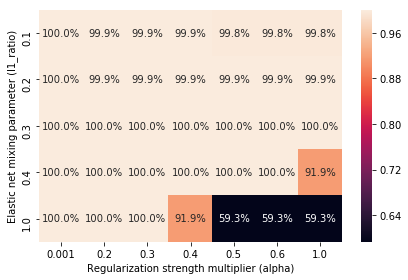

In [13]:
cv_heatmap_file = pathlib.Path("figures", "cross_validation", "cv_example_heatmap.png")

cv_results = pd.concat([pd.DataFrame(cv_pipeline.cv_results_)
                          .drop('params', axis=1),
                        pd.DataFrame.from_records(cv_pipeline
                                                  .cv_results_['params'])],
                       axis=1)

# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_results, values='mean_test_score',
                              index='classify__l1_ratio',
                              columns='classify__alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)')
plt.tight_layout()
plt.savefig(cv_heatmap_file, dpi=600, bbox_inches='tight')

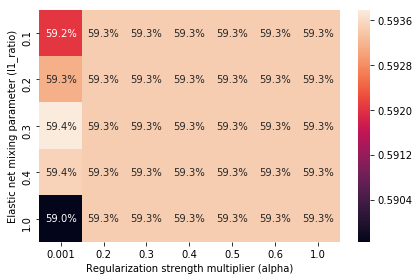

In [14]:
cv_heatmap_file = pathlib.Path("figures", "cross_validation", "cv_example_heatmap_shuffled.png")

cv_results = pd.concat([pd.DataFrame(shuffle_cv_pipeline.cv_results_)
                          .drop('params', axis=1),
                        pd.DataFrame.from_records(cv_pipeline
                                                  .cv_results_['params'])],
                       axis=1)

# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_results, values='mean_test_score',
                              index='classify__l1_ratio',
                              columns='classify__alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)')
plt.tight_layout()
plt.savefig(cv_heatmap_file, dpi=600, bbox_inches='tight')

## Generate Predictions

In [15]:
y_predict_train = cv_pipeline.decision_function(x_train_df)
y_predict_test = cv_pipeline.decision_function(x_test_df)

y_predict_shuffled_train = shuffle_cv_pipeline.decision_function(x_train_shuffled_df)
y_predict_shuffled_test = shuffle_cv_pipeline.decision_function(x_test_df)

In [16]:
y_test_meta_df = (
    y_test_df
    .assign(predicted=y_predict_test,
            predicted_shuffle=y_predict_shuffled_test)
    .merge(meta_test_df, left_index=True, right_index=True)
)
y_train_meta_df = (
    y_train_df
    .assign(predicted = y_predict_train,
            predicted_shuffle = y_predict_shuffled_train)
    .merge(meta_train_df, left_index=True, right_index=True)
)

In [17]:
y_train_meta_df.head()

,Metadata_CellLine_x,status,predicted,predicted_shuffle,Metadata_TableNumber,Metadata_ImageNumber,Metadata_Plate,Metadata_Well,Metadata_plate_map_name,Metadata_CellLine_y,Metadata_Dosage
0,CloneE,1,0.516514,0.395826,114831207981486473749639607857042574926,152,207106_exposure320,B09,PlateMap_207106_exposure320,CloneE,0.0
1,WT,0,-0.112133,-0.053858,170121651517565003287733984386396675981,111,207106_exposure320,B04,PlateMap_207106_exposure320,WT,0.0
2,CloneE,1,0.367343,-0.042281,192659163443149018870286705783741514663,188,207106_exposure320,B09,PlateMap_207106_exposure320,CloneE,0.0
3,WT,0,-0.133077,0.360424,156451505594144181796073459378722482594,254,207106_exposure320,B03,PlateMap_207106_exposure320,WT,0.0
4,CloneE,1,0.420688,0.307323,114831207981486473749639607857042574926,152,207106_exposure320,B09,PlateMap_207106_exposure320,CloneE,0.0


## Obtain Performance Metrics

In [18]:
y_train_metrics = get_threshold_metrics(
    y_true=y_train_meta_df.status.astype(float),
    y_pred=y_train_meta_df.predicted
)

y_test_metrics = get_threshold_metrics(
    y_true=y_test_meta_df.status.astype(float),
    y_pred=y_test_meta_df.predicted
)

y_train_shuffle_metrics = get_threshold_metrics(
    y_true=y_train_meta_df.status.astype(float),
    y_pred=y_train_meta_df.predicted_shuffle
)

y_test_shuffle_metrics = get_threshold_metrics(
    y_true=y_test_meta_df.status.astype(float),
    y_pred=y_test_meta_df.predicted_shuffle
)

## Inspect Classifier Coefficients

In [19]:
# Save classifier coefficients
final_pipeline = shuffle_cv_pipeline.best_estimator_
final_classifier = final_pipeline.named_steps['classify']

coef_df = pd.DataFrame.from_dict(
    {'feature': x_train_df.columns,
     'weight': final_classifier.coef_[0]}
)

nonzero_model_coef_df = coef_df.query("weight != 0").sort_values(by="weight").reset_index(drop=True)
print(nonzero_model_coef_df.shape)
nonzero_model_coef_df.head()

(329, 2)


,feature,weight
0,Nuclei_Texture_DifferenceEntropy_RNA_5_01,-0.070555
1,Cells_Correlation_K_DNA_ER,-0.065280
2,Nuclei_RadialDistribution_RadialCV_AGP_2of4,-0.059186
3,Nuclei_Texture_SumEntropy_RNA_5_01,-0.057868
4,Nuclei_Texture_InfoMeas1_RNA_5_01,-0.057840


In [20]:
# Save classifier coefficients
final_pipeline = cv_pipeline.best_estimator_
final_classifier = final_pipeline.named_steps['classify']

coef_df = pd.DataFrame.from_dict(
    {'feature': x_train_df.columns,
     'weight': final_classifier.coef_[0]}
)

nonzero_model_coef_df = coef_df.query("weight != 0").sort_values(by="weight").reset_index(drop=True)
print(nonzero_model_coef_df.shape)
nonzero_model_coef_df

(7, 2)


,feature,weight
0,Nuclei_Intensity_MinIntensityEdge_DNA,-0.107459
1,Nuclei_Intensity_MinIntensity_DNA,-0.107459
2,Nuclei_Correlation_K_ER_RNA,-0.034183
3,Nuclei_Intensity_MeanIntensityEdge_DNA,-0.023384
4,Cells_Granularity_1_AGP,0.011710
5,Cytoplasm_Granularity_1_AGP,0.014189
6,Nuclei_Correlation_K_RNA_ER,0.029023


In [21]:
metrics_list = [
    ('Training', y_train_metrics),
    ('Testing', y_test_metrics),
    ('Training Shuffled', y_train_shuffle_metrics),
    ('Testing Shuffled', y_test_shuffle_metrics)
]

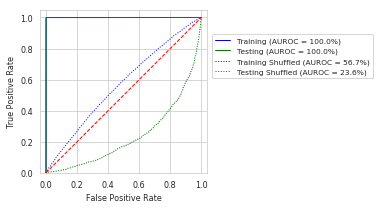

In [22]:
# Plot ROC
roc_file = pathlib.Path("figures", "metrics", "example_roc.png")

sns.set_style("whitegrid")
plt.figure(figsize=(3, 3))
total_auroc = {}
colors = ['blue', 'green', 'blue', 'green']
linestyle = ["solid", "solid", "dotted", "dotted"]
idx = 0
for label, metrics in metrics_list:
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
             label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']),
             linewidth=1, linestyle=linestyle[idx], c=colors[idx])
    total_auroc[label] = metrics['auroc']
    idx += 1

plt.axis('equal')
plt.plot([0, 1], [0, 1], color='red', linewidth=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=8)
plt.ylabel('True Positive Rate', fontsize=8)
plt.title('')
plt.tick_params(labelsize=8)
lgd = plt.legend(bbox_to_anchor=(1.03, 0.85),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=7.5)

plt.savefig(roc_file, dpi=600, bbox_extra_artists=(lgd,),
            bbox_inches='tight')

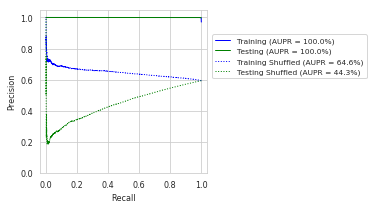

In [23]:
# Plot PR
pr_file = pathlib.Path("figures", "metrics", "example_pr.png")

sns.set_style("whitegrid")
plt.figure(figsize=(3, 3))
total_aupr = {}
idx = 0

for label, metrics in metrics_list:
    pr_df = metrics['pr_df']
    plt.plot(pr_df.recall, pr_df.precision,
             label='{} (AUPR = {:.1%})'.format(label, metrics['average_precision']),
             linewidth=1, linestyle=linestyle[idx], c=colors[idx])
    total_aupr[label] = metrics['average_precision']
    idx += 1

plt.axis('equal')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=8)
plt.ylabel('Precision', fontsize=8)
plt.title('')
plt.tick_params(labelsize=8)
lgd = plt.legend(bbox_to_anchor=(1.03, 0.85),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=7.5)

plt.savefig(pr_file,
            dpi=600,
            bbox_extra_artists=(lgd,),
            bbox_inches='tight')

## Apply Models to Holdout Data

In [24]:
clone_a_file = pathlib.Path("data", "example_holdout_clone_a.tsv.gz")
clone_a_holdout_df = pd.read_csv(clone_a_file, sep="\t")

clone_e_holdout_file = pathlib.Path("data", "example_holdout_clone_e_holdout.tsv.gz")
clone_e_holdout_df = pd.read_csv(clone_e_holdout_file, sep="\t")

wt_holdout_file = pathlib.Path("data", "example_holdout_wt_holdout.tsv.gz")
wt_holdout_df = pd.read_csv(wt_holdout_file, sep="\t")

In [25]:
clone_a_predict = cv_pipeline.decision_function(clone_a_holdout_df.reindex(x_train_df.columns, axis="columns"))
clone_e_holdout_predict = cv_pipeline.decision_function(clone_e_holdout_df.reindex(x_train_df.columns, axis="columns"))
wt_holdout_predict = cv_pipeline.decision_function(wt_holdout_df.reindex(x_train_df.columns, axis="columns"))

In [26]:
clone_a_pred_df = pd.DataFrame().assign(
    pred=clone_a_predict,
    clone="clone_a"
)
clone_e_pred_df = pd.DataFrame().assign(
    pred=clone_e_holdout_predict,
    clone="clone_e"
)
wt_pred_df = pd.DataFrame().assign(
    pred=wt_holdout_predict,
    clone="wt"
)

holdout_df = pd.concat([clone_a_pred_df, clone_e_pred_df, wt_pred_df])
holdout_df.head()

,pred,clone
0,0.376661,clone_a
1,0.448868,clone_a
2,0.185841,clone_a
3,0.058902,clone_a
4,0.562085,clone_a


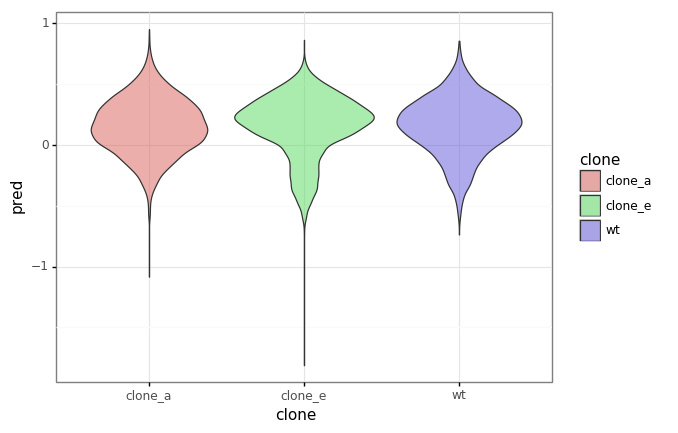

<ggplot: (-9223363244462115068)>

In [27]:
(
    gg.ggplot(holdout_df, gg.aes(y="pred", x="clone")) +
    gg.geom_violin(gg.aes(fill="clone"), alpha=0.5) +
    gg.theme_bw()
)

In [28]:
holdout_df.groupby("clone").describe()

pred                                                             \
          count     mean       std       min       25%       50%       75%   
clone                                                                        
clone_a  9236.0  0.15648  0.227086 -1.083169  0.005546  0.155918  0.315102   
clone_e  7023.0  0.15648  0.250141 -1.811061  0.044344  0.200417  0.327948   
wt       6453.0  0.15648  0.236764 -0.735859  0.018325  0.175408  0.317625   

                   
              max  
clone              
clone_a  0.951758  
clone_e  0.864035  
wt       0.856968